# Hyperbolic K-Means Clustering
`Drew Wilimitis`

In this notebook, I apply hyperbolic k-means clustering to network data embedded in the Poincaré disk. To generate the embeddings, I use the poincare model provided by the `gensim` library. <br>

If class labels are also known for these networks datasets, a modified approach is used to perform supervised learning. K-means clustering is applied to a training set to partition the embedding space by ground truth labels, and then predictions are made on a separate test set by assigning the class label corresponding to the nearest centroid.   
<br>

**Note:** the poincare model embeds **unweighted**, **undirected** graphs.

### Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

### Load libraries and helper functions

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# import modules within repository
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils' # path to utils folder
sys.path.append(my_path)
from utils import *
from embed import train_embeddings, load_embeddings, evaluate_model
from hkmeans import HyperbolicKMeans, plot_clusters

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# Unsupervised Clustering

## Enron email corpus

Organizational social network data based on email interaction among Enron employees<br>
108926 edges, 184 nodes, no class labels

In [2]:
# read in and clean enron email data
emails = pd.read_table('enron/emails.txt', delimiter=' ', header=None)
emails = emails[emails.iloc[:, 1] != emails.iloc[:, 2]].reset_index(drop=True)
emails.iloc[:, 1:].to_csv('enron/enron_relations.csv', index=False)
edge_list = []
for i in range(emails.shape[0]):
    edge_list.append(list(emails.iloc[i, 1:]))
employees = pd.read_csv('enron/employee_info.csv')
employees = employees.fillna('NA')

# load embedding vectors
emb = load_embeddings('models/enron_vectors')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

# get node attributes
names = employees['first'].values + ' ' + employees['last'].values
names = names + ' (' + employees['title'] + ')'
enron_dict = {}
for i in range(emb.shape[0]):
    enron_dict[names[i]] = emb_data[i]

(184, 2)

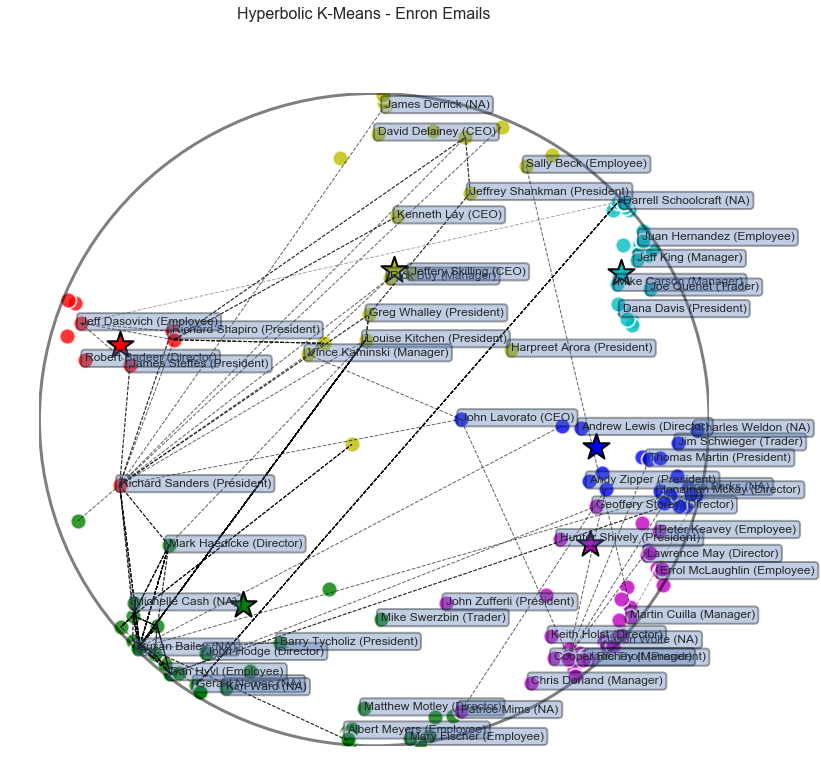

In [3]:
# fit hyperbolic kmeans clusters to embedding vectors
hkmeans = HyperbolicKMeans(n_clusters=6)
hkmeans.fit(emb_data, max_epochs=10)

# plot results
plot_clusters(emb, labels = hkmeans.assignments, centroids = hkmeans.centroids, edge_list=edge_list,
              add_labels=True, label_dict=enron_dict, label_frac = 0.001, edge_frac = 0.01, width=12, height=12, title='Enron Emails')

## WordNET Mammals Subtree

In [5]:
# load pre-trained embedding vectors
emb = load_embeddings('models/mammals_vectors.csv')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

# fit clusters
hkmeans = HyperbolicKMeans(n_clusters=6)
hkmeans.fit(emb_data, max_epochs=15)
y = hkmeans.assignments
centroids = hkmeans.centroids

# get node attributes
mammal_dict = {}
mammals = emb['node'].values
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[mammals[i]] = np.argmax(y[i])

for i in range(emb.shape[0]):
    mammal_dict[mammals[i]] = emb_data[i]

(1182, 2)

In [6]:
def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

def plot_mammals(embedding_dict, label_frac=0.001, plot_frac=0.6, title=None, 
                   save_fig=False):
    colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']
    fig = plt.figure(figsize=(9,9))
    plt.grid('off')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.axis('off')
    ax = plt.gca()
    embed_vals = np.array(list(embedding_dict.values()))
    keys = list(embedding_dict.keys())
    min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
    labeled_vals = np.array([2*embed_vals.max(axis=0)])
    groups = [keys[i] for i in np.argsort(np.linalg.norm(embed_vals, axis=1))][:10]
    groups.insert(0, 'mammal.n.01')
    for key in groups:
        if np.min(dist_squared(embedding_dict[key], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.scatter(embedding_dict[key][0], embedding_dict[key][1], s=40, c=colors[label_dict[key]])
            props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.5)
            _ = ax.text(embedding_dict[key][0], embedding_dict[key][1]+0.01, s=key.split('.')[0], 
                        size=10, fontsize=12, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embedding_dict[key]))
    n = int(plot_frac*len(embed_vals))
    for i in np.random.permutation(len(embed_vals))[:n]:
        _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
        if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0], 
                        size=9, fontsize=11, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    if title != None:
        plt.title(title, size=16)
    if save_fig:
        plt.savefig('../images/mammals_kmeans.png')
    plt.show();

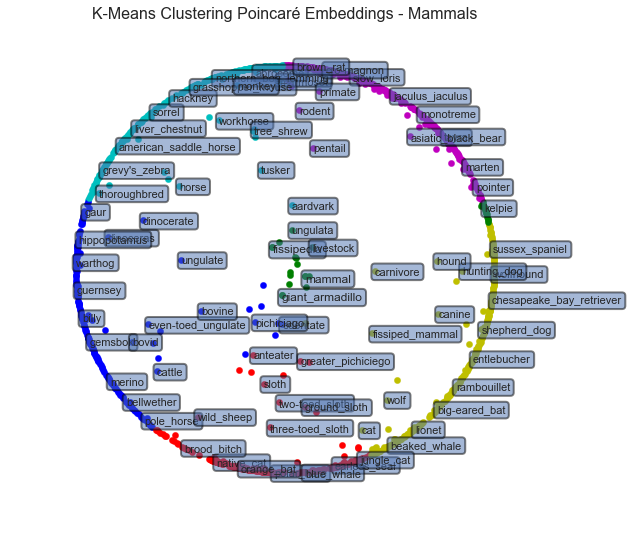

In [7]:
plot_mammals(mammal_dict, plot_frac=1, label_frac=0.003,
               title='K-Means Clustering Poincaré Embeddings - Mammals', save_fig=False)

# Supervised Learning Examples

We now adapt the hyperbolic KMeans algorithm for supervised learning, where the K centroids are produced by a random training subset and classification predictions are made on a separate holdout test set. 

##  Zachary karate club network

Undirected graph connecting members (nodes) of a karate club <br>
34 nodes, 78 edges, split into 2 different classes

In [2]:
# load original file to get edge list
karate_df = pd.read_csv('../data/ucidata-zachary/out.tsv', delimiter=' ', header=None)
edge_list = []
for i in range(karate_df.shape[0]):
    edge_list.append(list(karate_df.iloc[i, :]))

# load data with relation/graph edges (u,v)
fp = '../data/ucidata-zachary/out.tsv'
# train poincare embeddings and save output embed coordinates
train_embeddings(input_path=fp, delimiter=' ', output_path=os.path.join('models','karate_vectors'))

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 78 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=10
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 34x2 projection weights into models\karate_vectors


Cluster variance:  1.4920416867957824
Inertia (poincaré dist):  48.14373757100027


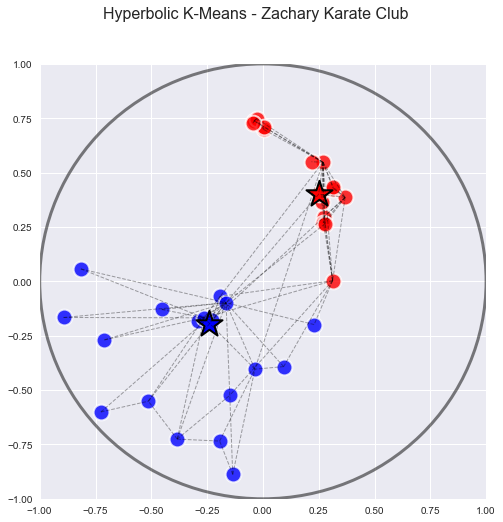

In [3]:
# load embedding vectors
emb = load_embeddings('models/karate_vectors')
emb_data = np.array(emb.iloc[:, 1:3])

# fit unsupervised clusters and plot results
hkmeans = HyperbolicKMeans(n_clusters=2)
hkmeans.fit(emb_data, max_epochs=15)
print('Cluster variance: ', hkmeans.variances)
print('Inertia (poincaré dist): ', hkmeans.inertia_)
plot_clusters(emb, labels=hkmeans.assignments, centroids=hkmeans.centroids, edge_list=edge_list, title='Zachary Karate Club')

In [10]:
# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
              0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y = y[emb.node.values - 1]
X = emb_data

# evaluate predictions
kmeans_clf = HyperbolicKMeans(n_clusters=2)
karate_scores = evaluate_model(kmeans_clf, X, y, report=True)
print('CV avg macro f1-score:', np.mean(karate_scores))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

CV avg macro f1-score: 1.0


### NCAA football teams

614 undirected edges, 115 NCAA teams (nodes), 12 classes 

In [17]:
# load graph data from networkx
G = nx.read_gml('football/football.gml', label='id')
football_df = pd.DataFrame(np.array(list(G.edges())), columns=['u', 'v'])
#football_df.to_csv('football/football_relations.csv', index=False)
edge_list = []
for i in range(football_df.shape[0]):
    edge_list.append(list(football_df.iloc[i, :]))

# load pre-trained embedding coordinates
emb = load_embeddings('models/football_vectors')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

# fit hyperbolic kmeans 
hkmeans = HyperbolicKMeans(n_clusters=12)
hkmeans.fit(emb_data, max_epochs=8)
y = hkmeans.assignments
centroids = hkmeans.centroids

(115, 2)

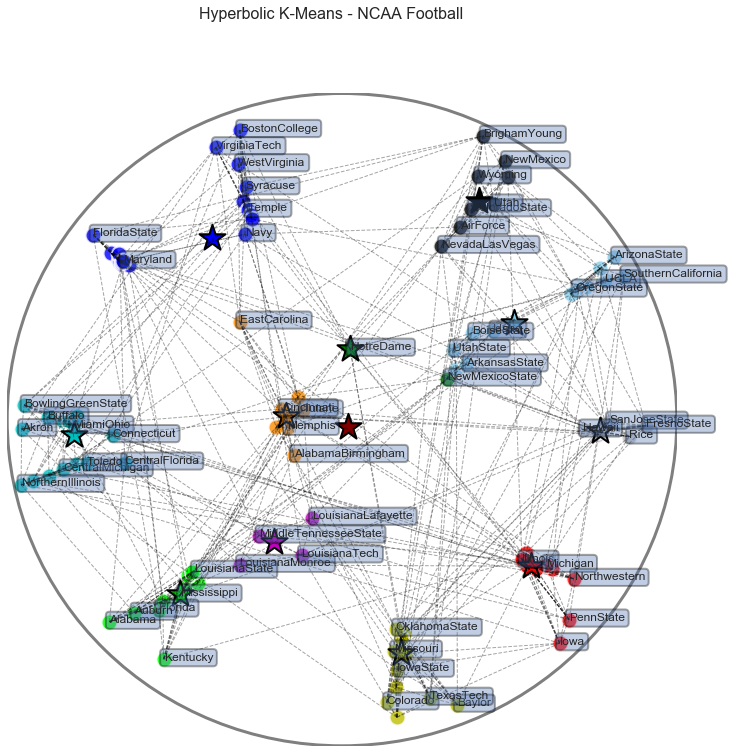

In [18]:
# get team name labels with embedding coords
G = nx.read_gml('football/football.gml', label='id')
teams = []
for i in range(emb.shape[0]):
    teams.append(G.node[i]['label'])

ncaa_labels = []
for i in range(emb.shape[0]):
    ncaa_labels.append(G.node[i]['value'])

football_dict = {}
for i in range(emb.shape[0]):
    football_dict[teams[i]] = emb_data[i]

# plot results
plot_clusters(emb, y, centroids, edge_list, add_labels=True, label_dict=football_dict,
              label_frac = 0.001, width=12, height=12, title='NCAA Football')

In [19]:
# true class labels 
y = np.array(ncaa_labels)
X = emb_data

# evaluate predictions
kmeans_clf = HyperbolicKMeans(n_clusters=12)
football_scores = evaluate_model(kmeans_clf, X, y, max_epochs=7, report=True)
print('CV avg macro f1-score:', np.mean(football_scores))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.20      1.00      0.33         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         2
           9       0.75      1.00      0.86         3
          10       0.14      0.50      0.22         2
          11       1.00      0.67      0.80         3

   micro avg       0.51      0.51      0.51        35
   macro avg       0.38      0.51      0.41        35
weighted avg       0.46      0.51      0.47        35

CV avg macro f1-score: 0.5039437229437229


## Polbooks

441 undirected edges, 105 nodes, 3 classes 

In [21]:
# load polbooks data
polbooks_df = pd.read_table('polbooks/out.dimacs10-polbooks', delimiter='\t')
polbooks_df = polbooks_df.reset_index()
u = polbooks_df.iloc[:, 0]
v = polbooks_df.iloc[:, 1]
polbooks_df.shape
polbooks_df.columns = ['u', 'v']
edge_list = []
for i in range(polbooks_df.shape[0]):
    edge_list.append(list(polbooks_df.iloc[i, :]))
#polbooks_df.to_csv('polbooks_relations.csv', index=False)

# load pre-trained embedding coordinates
emb = load_embeddings('models/polbooks_vectors')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

(441, 2)

(105, 2)

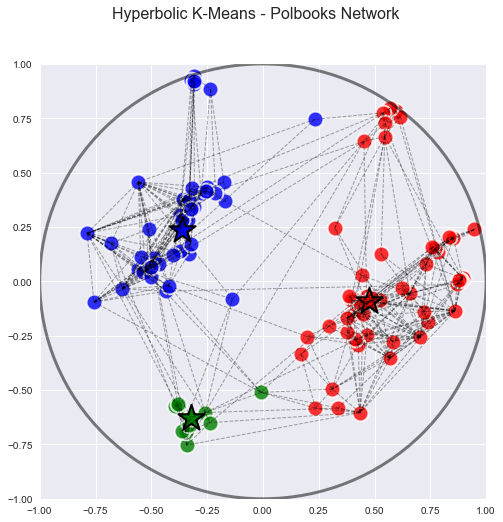

In [22]:
# fit unsupervised clustering
hkmeans = HyperbolicKMeans(n_clusters=3)
hkmeans.fit(emb_data, max_epochs=15)

# plot results
plot_clusters(emb, labels=hkmeans.assignments, centroids = hkmeans.centroids, edge_list=edge_list, title='Polbooks Network')

In [23]:
# get true class labels
G = nx.read_gml('polbooks/polbooks.gml.txt', label='id')
labels = []
for i in range(emb.shape[0]):
    labels.append(G.node[i]['value'])
labels = np.array(labels)
class_map = {'n': 0, 'c': 1, 'l': 2}
polbook_labels = np.array([class_map[x] for x in labels])

# predict and evaluate results 
y_true = polbook_labels
y = y_true[emb.node.values.astype('int')-1]
X = emb_data
kmeans_clf = HyperbolicKMeans(n_clusters=3)
polbooks_scores = evaluate_model(kmeans_clf, X, y, max_epochs=15, report=True)
print('CV avg macro f1-score:', np.mean(polbooks_scores))

              precision    recall  f1-score   support

           0       0.10      0.14      0.12         7
           1       0.60      0.90      0.72        10
           2       0.71      0.33      0.45        15

   micro avg       0.47      0.47      0.47        32
   macro avg       0.47      0.46      0.43        32
weighted avg       0.54      0.47      0.46        32

CV avg macro f1-score: 0.44107622423411896


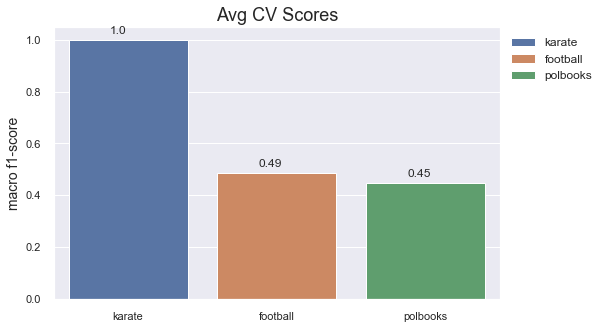

In [67]:
result_df = pd.DataFrame(columns=['dataset', 'avg_f1'])
result_df['dataset'] = np.array(['karate', 'football', 'polbooks'])
avg_scores = [np.mean(karate_scores), np.mean(football_scores), np.mean(polbooks_scores)]
result_df['avg_f1'] = np.array(avg_scores)
plt.figure(figsize=(8,5))
plt.style.use('seaborn')
sns.set(style="darkgrid")
ax = sns.barplot(data=result_df, x='dataset', y='avg_f1', hue='dataset', dodge=False, ci=None);
ax.set_title('Avg CV Scores', size=18)
ax.set_ylabel('macro f1-score', size=14)
ax.set_xlabel(None)
# add values onto barplot display
for i, score in enumerate(avg_scores):
    ax.text(i-0.125, np.mean(score)+0.025, str(np.round(np.mean(score), 2)))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["karate", "football", 'polbooks'],
          fontsize=12, loc='best', bbox_to_anchor=(1, 1));
plt.show();

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).